In [3]:
import os
import toml
import pandas as pd
from utils.config_helper import update_nested_toml, load_config

breast
lung
prostate
stomach
rectal

In [4]:
TYPE = input("Enter the type of the config file: ")
CONFIG_PATH = f"../config/{TYPE}.toml"
config = load_config(CONFIG_PATH)

In [5]:
def inspect_nan(df, name):
    print(df[pd.isna(df[name])])

In [6]:
beta_file_number = config["init"]["hyper"]["beta_file_number"]
test_ratio = config["init"]["hyper"]["test_ratio"]
seed = config["init"]["hyper"]["splitting_seed"]
normal_number_0 = config["init"]["hyper"]["normal_number_0"]
if beta_file_number == 2:
    normal_number_1 = config["init"]["hyper"]["normal_number_1"]
data_source = config["init"]["hyper"]["data_source"]
is_columns_duplicated = config["init"]["hyper"]["is_columns_duplicated"]
if data_source == "GDC_stomach_GSE99553":  # god forgive me
    is_columns_duplicated_1 = config["init"]["hyper"]["is_columns_duplicated_1"]

In [7]:
trainOutPath = f"../{TYPE}/result/{data_source}/train{int(100-test_ratio*100)}"
testOutPath = f"../{TYPE}/result/{data_source}/test{int(test_ratio*100)}"

### Section. 0 Merge and Split Champ Data 
(if there are more than one normalized beta data)

#### Summary
- beta data is split into train and test
- all beta data will the following format
  - column 0 is the id of the sample
  - column 1 to n is the beta value of each CpG site
  - normal samples come first, then tumor samples

In [6]:
df0 = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/all_beta_normalized_0.csv")

In [7]:
if beta_file_number == 2:
    df1 = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/all_beta_normalized_1.csv")

In [8]:
# DEBUG
df0
# END

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,909,910,911,912,913,914,915,916,917,918
0,cg00000957,0.870131,0.870131,0.855272,0.855272,0.837964,0.837964,0.881787,0.881787,0.840490,...,0.847760,0.847760,0.828761,0.828761,0.854923,0.854923,0.845223,0.845223,0.868674,0.868674
1,cg00001349,0.805265,0.805265,0.786301,0.786301,0.812133,0.812133,0.702542,0.702542,0.794556,...,0.827351,0.827351,0.795160,0.795160,0.783938,0.783938,0.740427,0.740427,0.517052,0.517052
2,cg00001583,0.130379,0.130379,0.105195,0.105195,0.069474,0.069474,0.065219,0.065219,0.083583,...,0.241279,0.241279,0.413970,0.413970,0.272795,0.272795,0.443902,0.443902,0.051824,0.051824
3,cg00002028,0.027859,0.027859,0.028367,0.028367,0.035275,0.035275,0.009818,0.009818,0.040193,...,0.031782,0.031782,0.030371,0.030371,0.043669,0.043669,0.052163,0.052163,0.032497,0.032497
4,cg00002719,0.024905,0.024905,0.028116,0.028116,0.026357,0.026357,0.031588,0.031588,0.049386,...,0.523305,0.523305,0.032755,0.032755,0.463249,0.463249,0.254924,0.254924,0.715903,0.715903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120672,cg15728744,0.989299,0.989299,0.984082,0.984082,0.975333,0.975333,0.992034,0.992034,0.959184,...,0.970321,0.970321,0.885888,0.885888,0.892856,0.892856,0.989962,0.989962,0.959804,0.959804
120673,cg15728779,0.455539,0.455539,0.461929,0.461929,0.397068,0.397068,0.394965,0.394965,0.405328,...,0.350407,0.350407,0.295748,0.295748,0.320699,0.320699,0.223251,0.223251,0.235275,0.235275
120674,cg15729771,0.057365,0.057365,0.049908,0.049908,0.061390,0.061390,0.045488,0.045488,0.048277,...,0.065144,0.065144,0.072834,0.072834,0.053064,0.053064,0.046125,0.046125,0.077101,0.077101
120675,cg15730248,0.958313,0.958313,0.954312,0.954312,0.953241,0.953241,0.962748,0.962748,0.928654,...,0.843446,0.843446,0.926867,0.926867,0.895288,0.895288,0.968495,0.968495,0.951945,0.951945


In [9]:
# DEBUG
df1
# END

,Unnamed: 0,1,2,3,4,5,6,7,8,9,...,909,910,911,912,913,914,915,916,917,918
0,cg00000957,0.873237,0.873237,0.870941,0.870941,0.859828,0.859828,0.883027,0.883027,0.878071,...,0.799261,0.799261,0.330985,0.330985,0.860865,0.860865,0.869139,0.869139,0.865573,0.865573
1,cg00001349,0.813589,0.813589,0.779412,0.779412,0.881907,0.881907,0.740944,0.740944,0.848596,...,0.835029,0.835029,0.780882,0.780882,0.716940,0.716940,0.752071,0.752071,0.859589,0.859589
2,cg00001583,0.060897,0.060897,0.071685,0.071685,0.073219,0.073219,0.079168,0.079168,0.055963,...,0.547632,0.547632,0.658158,0.658158,0.196573,0.196573,0.238353,0.238353,0.687156,0.687156
3,cg00002028,0.020690,0.020690,0.025741,0.025741,0.011456,0.011456,0.014352,0.014352,0.032681,...,0.031653,0.031653,0.056207,0.056207,0.044863,0.044863,0.038549,0.038549,0.023179,0.023179
4,cg00002719,0.031898,0.031898,0.023960,0.023960,0.047802,0.047802,0.025617,0.025617,0.039806,...,0.657312,0.657312,0.687780,0.687780,0.063309,0.063309,0.076774,0.076774,0.673089,0.673089
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360237,cg27656573,0.958146,0.958146,0.956567,0.956567,0.960663,0.960663,0.952006,0.952006,0.961032,...,0.941653,0.941653,0.878673,0.878673,0.955497,0.955497,0.947089,0.947089,0.963040,0.963040
360238,cg27657363,0.949939,0.949939,0.955772,0.955772,0.945914,0.945914,0.958400,0.958400,0.967471,...,0.660955,0.660955,NaN,NaN,0.925782,0.925782,0.925081,0.925081,0.804342,0.804342
360239,cg27657537,0.069554,0.069554,0.055817,0.055817,0.045695,0.045695,0.049810,0.049810,0.053926,...,0.032993,0.032993,NaN,NaN,0.088574,0.088574,0.111038,0.111038,0.087881,0.087881
360240,cg27662611,0.027544,0.027544,0.027796,0.027796,0.044085,0.044085,0.022501,0.022501,0.058010,...,0.038424,0.038424,NaN,NaN,0.029692,0.029692,0.048457,0.048457,0.053156,0.053156


In [10]:
# potential feature loss
if beta_file_number == 2:
    feature_name_0 = df0.iloc[:, 0].tolist()
    feature_name_1 = df1.iloc[:, 0].tolist()

    feature_name = list(set(feature_name_0).intersection(feature_name_1))
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_0", len(feature_name_0)
    )
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_1", len(feature_name_1)
    )
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_intersection", len(feature_name)
    )
elif beta_file_number == 1:
    feature_name = df0.iloc[:, 0].tolist()
    update_nested_toml(
        "preprocess.merge_and_split", "feature_size_0", len(feature_name)
    )

In [11]:
if beta_file_number == 2:
    df0_join = df0[df0.iloc[:, 0].isin(feature_name)]
    df1_join = df1[df1.iloc[:, 0].isin(feature_name)]

In [12]:
if beta_file_number == 2:
    df0_join = df0_join.iloc[:, 1::is_columns_duplicated]
    if data_source == "GDC_stomach_GSE99553":  # god forgive me
        df1_join = df1_join.iloc[:, 1::is_columns_duplicated_1]
    else:
        df1_join = df1_join.iloc[:, 1::is_columns_duplicated]
    df0_join.reset_index(drop=True, inplace=True)
    df1_join.reset_index(drop=True, inplace=True)
    df0_join_normal = df0_join.iloc[:, :normal_number_0]
    df0_join_tumor = df0_join.iloc[:, normal_number_0:]
    df1_join_normal = df1_join.iloc[:, :normal_number_1]
    df1_join_tumor = df1_join.iloc[:, normal_number_1:]
elif beta_file_number == 1:
    df0_join = df0.iloc[:, 1::is_columns_duplicated]

In [13]:
if beta_file_number == 2:
    df_normal = pd.concat([df0_join_normal, df1_join_normal], axis=1)
    df_tumor = pd.concat([df0_join_tumor, df1_join_tumor], axis=1)

In [14]:
# drop those samples with missing value
# note: could use padding or other methods to fill the missing value

if beta_file_number == 2:
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_dfn_shape", df_normal.shape
    )
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_dfc_shape", df_tumor.shape
    )
    df_normal.dropna(inplace=True, axis=1)
    df_tumor.dropna(inplace=True, axis=1)
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_dfn_shape", df_normal.shape
    )
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_dfc_shape", df_tumor.shape
    )
elif beta_file_number == 1:
    update_nested_toml(
        "preprocess.merge_and_split", "Before_dropna_df_shape", df0_join.shape
    )
    df0_join.dropna(inplace=True, axis=1)
    update_nested_toml(
        "preprocess.merge_and_split", "After_dropna_df_shape", df0_join.shape
    )

In [15]:
# Combine the normal and tumor data
if beta_file_number == 2:
    X = pd.concat([df_normal, df_tumor], axis=1).T
    y = [0] * df_normal.shape[1] + [1] * df_tumor.shape[1]
elif beta_file_number == 1:
    X = df0_join.T
    y = [0] * normal_number_0 + [1] * (df0_join.shape[1] - normal_number_0)


In [32]:
from collections import Counter
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_ratio, random_state=seed
)

In [33]:
update_nested_toml(
    "preprocess.merge_and_split", "Before_SMOTE_X_train_shape", X_train.shape
)
update_nested_toml(
    "preprocess.merge_and_split", "Before_SMOTE_y_train_shape", len(y_train)
)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=seed)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)
update_nested_toml(
    "preprocess.merge_and_split", "After_SMOTE_X_train_shape", X_resampled.shape
)
update_nested_toml(
    "preprocess.merge_and_split", "After_SMOTE_y_train_shape", len(y_resampled)
)


In [34]:
X_resampled

,0,1,2,3,4,5,6,7,8,9,...,115109,115110,115111,115112,115113,115114,115115,115116,115117,115118
0,0.841756,0.703298,0.431084,0.027505,0.397063,0.465172,0.249965,0.949241,0.012780,0.262894,...,0.027010,0.920087,0.850160,0.930655,0.791388,0.989132,0.384792,0.038485,0.973749,0.679401
1,0.878719,0.857571,0.079447,0.032354,0.046182,0.241271,0.315196,0.968882,0.026012,0.132082,...,0.022753,0.970901,0.661749,0.928384,0.682931,0.984485,0.495349,0.067969,0.942289,0.958157
2,0.802070,0.797716,0.096851,0.027988,0.017034,0.310766,0.233277,0.955857,0.015123,0.117587,...,0.040264,0.977996,0.726119,0.917069,0.759037,0.984149,0.420042,0.049243,0.947436,0.960082
3,0.862710,0.833682,0.316148,0.049158,0.329400,0.414738,0.204136,0.967899,0.014163,0.181442,...,0.024757,0.966543,0.646962,0.801688,0.803312,0.990239,0.416372,0.066303,0.980574,0.963004
4,0.892635,0.871973,0.510363,0.017838,0.430559,0.181806,0.155549,0.973625,0.022387,0.045736,...,0.029056,0.739023,0.643690,0.951082,0.654773,0.977833,0.497420,0.067781,0.979291,0.956772
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.878729,0.865951,0.089815,0.021578,0.023333,0.289873,0.295743,0.967093,0.015089,0.120200,...,0.036278,0.982500,0.759131,0.931467,0.737107,0.984409,0.463074,0.061237,0.962958,0.972720
1082,0.814309,0.765022,0.093404,0.026295,0.019902,0.322114,0.232296,0.955015,0.012538,0.112805,...,0.039917,0.975547,0.716257,0.917594,0.744179,0.983871,0.435207,0.047847,0.939098,0.957803
1083,0.849890,0.897346,0.067199,0.011073,0.031814,0.308065,0.240790,0.975927,0.016051,0.064191,...,0.044021,0.975818,0.638132,0.951337,0.741305,0.987540,0.402084,0.056576,0.958052,0.967637
1084,0.864610,0.707271,0.100759,0.023600,0.029610,0.336432,0.252440,0.954921,0.022920,0.120200,...,0.033460,0.973117,0.647463,0.915533,0.692098,0.981847,0.324761,0.047862,0.916655,0.956687


In [35]:
train_class_distribution = Counter(y_resampled)
testing_class_distribution = Counter(y_test)

update_nested_toml("preprocess.merge_and_split", "training_set_samples", len(X_resampled))
update_nested_toml("preprocess.merge_and_split", "testing_set_samples", len(X_test))
update_nested_toml(
    "preprocess.merge_and_split",
    "training_class_distribution",
    [train_class_distribution[0], train_class_distribution[1]],
)
update_nested_toml(
    "preprocess.merge_and_split",
    "testing_class_distribution",
    [testing_class_distribution[0], testing_class_distribution[1]],
)

In [36]:
X_resampled.columns = feature_name
X_resampled["label"] = y_resampled
X_resampled.sort_values(by=["label"], inplace=True)
train_df = X_resampled.T
train_df.columns = range(train_df.shape[1])

X_test.columns = feature_name
X_test["label"] = y_test
X_test.sort_values(by=["label"], inplace=True)
test_df = X_test.T
test_df.columns = range(test_df.shape[1])

train_df.insert(0, "Unnamed: 0", train_df.index)
train_df.reset_index(drop=True, inplace=True)
test_df.insert(0, "Unnamed: 0", test_df.index)
test_df.reset_index(drop=True, inplace=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_1312\1430446889.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X_resampled["label"] = y_resampled


In [37]:
# DEBUG
train_df
# END

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,1076,1077,1078,1079,1080,1081,1082,1083,1084,1085
0,cg11829380,0.863162,0.872752,0.842748,0.870104,0.865133,0.861854,0.853502,0.831978,0.828043,...,0.814367,0.840298,0.891623,0.889749,0.912506,0.881394,0.866206,0.833391,0.866083,0.870663
1,cg19345671,0.793271,0.809230,0.691481,0.824447,0.662419,0.887864,0.776712,0.749857,0.741992,...,0.779721,0.836410,0.916526,0.788692,0.917036,0.825727,0.795392,0.765461,0.830673,0.759323
2,cg13769834,0.114687,0.120948,0.086329,0.061610,0.082506,0.064574,0.139889,0.100763,0.090943,...,0.212315,0.562893,0.628250,0.405984,0.640967,0.606170,0.639977,0.433561,0.373610,0.164935
3,cg25795456,0.034696,0.025562,0.022618,0.019339,0.024973,0.025742,0.035390,0.027250,0.026746,...,0.008614,0.029170,0.027695,0.044917,0.009303,0.033762,0.047799,0.024714,0.044599,0.041490
4,cg25702335,0.039718,0.023963,0.027325,0.031946,0.043130,0.046582,0.035457,0.034015,0.027782,...,0.073684,0.237586,0.751319,0.111242,0.727385,0.391101,0.580766,0.046143,0.400281,0.035732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115115,cg15600987,0.442904,0.443174,0.471574,0.411660,0.442324,0.359102,0.374901,0.471972,0.429219,...,0.319562,0.402289,0.445595,0.339822,0.448358,0.448878,0.442842,0.319368,0.342104,0.216977
115116,cg10056854,0.052698,0.055184,0.045917,0.039327,0.053807,0.062856,0.061548,0.063179,0.051123,...,0.030377,0.052215,0.030419,0.066501,0.059183,0.059660,0.056958,0.056765,0.068061,0.049953
115117,cg03203197,0.939081,0.960303,0.919834,0.938879,0.936677,0.933900,0.945433,0.928534,0.943005,...,0.966007,0.959278,0.886782,0.933373,0.965012,0.972311,0.952748,0.947105,0.948618,0.952202
115118,cg03892838,0.941956,0.974191,0.952373,0.956868,0.933276,0.946977,0.944806,0.952743,0.949042,...,0.721367,0.976652,0.829595,0.689539,0.972567,0.956279,0.965551,0.930111,0.968978,0.955484


In [38]:
# DEBUG
test_df
# END

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,141,142,143,144,145,146,147,148,149,150
0,cg11829380,0.882055,0.844243,0.874959,0.837964,0.859828,0.867264,0.883532,0.866782,0.874302,...,0.874250,0.889290,0.899768,0.894932,0.858987,0.865169,0.836599,0.843830,0.886915,0.863374
1,cg19345671,0.848587,0.793554,0.814811,0.812133,0.881907,0.793186,0.847782,0.925544,0.786932,...,0.813906,0.779295,0.884628,0.843706,0.876446,0.860537,0.808591,0.696881,0.857415,0.871801
2,cg13769834,0.123222,0.099305,0.096527,0.069474,0.073219,0.146764,0.108394,0.070445,0.102171,...,0.642706,0.051394,0.683070,0.341776,0.027865,0.362868,0.023059,0.152538,0.347627,0.651526
3,cg25795456,0.085896,0.028458,0.021660,0.035275,0.011456,0.026836,0.029587,0.034231,0.025665,...,0.047845,0.022555,0.070825,0.030787,0.023187,0.045941,0.030418,0.028216,0.026659,0.053677
4,cg25702335,0.063606,0.025645,0.023367,0.026357,0.047802,0.027035,0.044525,0.049881,0.026789,...,0.412761,0.042028,0.370334,0.046550,0.354420,0.035670,0.025877,0.171156,0.625426,0.760026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115115,cg15600987,0.380426,0.440188,0.438925,0.397068,0.438248,0.482187,0.430714,0.421014,0.441116,...,0.518984,0.470090,0.406311,0.289743,0.260730,0.879570,0.194502,0.456111,0.463608,0.793403
115116,cg10056854,0.077322,0.071702,0.041557,0.061390,0.039365,0.046658,0.053691,0.075484,0.056167,...,0.072899,0.051264,0.102891,0.054960,0.040415,0.079437,0.052878,0.103272,0.066247,0.071990
115117,cg03203197,0.946231,0.943473,0.970245,0.953241,0.962961,0.947608,0.937107,0.969262,0.972769,...,0.956788,0.963590,0.960122,0.935863,0.802307,0.955470,0.928665,0.955653,0.963785,0.962310
115118,cg03892838,0.955418,0.969292,0.958887,0.950154,0.949991,0.960743,0.947887,0.971930,0.957371,...,0.954225,0.923363,0.899872,0.682922,0.835915,0.861241,0.955836,0.858045,0.971855,0.957601


In [39]:
os.makedirs(f"{trainOutPath}", exist_ok=True)
os.makedirs(
    f"{testOutPath}",
    exist_ok=True,
)

train_df.to_csv(f"{trainOutPath}/all_beta_normalized_0.csv", index=False)
test_df.to_csv(f"{testOutPath}/all_beta_normalized_1.csv", index=False)

In [40]:
del train_df, test_df

In [41]:
zip_filename = f"{TYPE}_beta_files.zip"

In [42]:
import zipfile

with zipfile.ZipFile(zip_filename, "w") as zipf:
    zipf.write(
        f"{trainOutPath}/all_beta_normalized_0.csv", arcname="all_beta_normalized_0.csv"
    )
    zipf.write(
        f"{testOutPath}/all_beta_normalized_1.csv", arcname="all_beta_normalized_1.csv"
    )

In [43]:
from api import utils
service = utils.authenticate_drive()

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=260407430533-mtnvh98d2pv3eo7mgb14h6en5827k7b5.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A14728%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.file&state=zkRitlI3rK9xVLPC7hIwofYz2hRV69&access_type=offline


INFO:google_auth_oauthlib.flow:"GET /?state=zkRitlI3rK9xVLPC7hIwofYz2hRV69&code=4/0AanRRrsAlCFZqdvSdq6thRCYlOzYqD9I8K-a_1YLt2RqCmkF8VMAsxo8pBEnxU8rhn6-WQ&scope=https://www.googleapis.com/auth/drive.file HTTP/1.1" 200 65
INFO:api.utils:New credentials obtained.
INFO:api.utils:Credentials saved to token.pickle.
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0


In [44]:
directory = utils.create_folder(service, TYPE)

Created folder 'lung' with ID: 1jyrsvxFbTjgrf4Pjf9S5eKfgOVycNQGo


In [45]:
utils.run_upload_with_separate_thread(service, directory, zip_filename)

INFO:api.utils:Upload 0% complete for lung_beta_files.zip
INFO:api.utils:Upload 0% complete for lung_beta_files.zip
INFO:api.utils:Upload 0% complete for lung_beta_files.zip
INFO:api.utils:Upload 0% complete for lung_beta_files.zip
INFO:api.utils:Upload 0% complete for lung_beta_files.zip
INFO:api.utils:Upload 1% complete for lung_beta_files.zip
INFO:api.utils:Upload 1% complete for lung_beta_files.zip
INFO:api.utils:Upload 1% complete for lung_beta_files.zip
INFO:api.utils:Upload 1% complete for lung_beta_files.zip
INFO:api.utils:Upload 1% complete for lung_beta_files.zip
INFO:api.utils:Upload 2% complete for lung_beta_files.zip
INFO:api.utils:Upload 2% complete for lung_beta_files.zip
INFO:api.utils:Upload 2% complete for lung_beta_files.zip
INFO:api.utils:Upload 2% complete for lung_beta_files.zip
INFO:api.utils:Upload 2% complete for lung_beta_files.zip
INFO:api.utils:Upload 3% complete for lung_beta_files.zip
INFO:api.utils:Upload 3% complete for lung_beta_files.zip
INFO:api.utils

### Sec. 1 dbeta calculation
#### Summary
- calculate the difference of beta value between tumor and normal samples
- the output file will have the following format
  - column 0 is the id of the sample
  - column 1 is the gene name
  - column 2 is the difference of beta value between tumor and normal samples

### Implementation
1. split normal and tumor samples
2. remove outliers in normal and tumor samples
3. calculate the mean of normal sammples
4. tumor - avg(normal)
5. calculate the mean of tumor samples
6. merge with DMP file
7. exclude the genes not in single comorbidity list

In [11]:
import gdown

##### Lung
https://drive.google.com/file/d/1cuKmDUgch4A0ULnj6XfTHuk6u0Xtz_3H/view?usp=sharing
##### Rectal
https://drive.google.com/file/d/11DZAwbtqVriSN8EhUNhQEEwVyntiycRa/view?usp=sharing
##### Stomach
https://drive.google.com/file/d/1QBklKEO61ZYqxo-gfjBsWg3mcREsTRc7/view?usp=sharing
##### Prostate
tbd
##### Breast
tbd

In [ ]:
url = input()

output = 'download.zip'

In [ ]:
gdown.download(url, output, quiet=False)

In [13]:
import zipfile
import shutil

with zipfile.ZipFile("download.zip", "r") as zip_ref:
    zip_ref.extractall("download")

shutil.move("download/all_beta_normalized_0.csv", f"all_beta_normalized_0.csv")
shutil.move("download/all_beta_normalized_1.csv", f"all_beta_normalized_1.csv")

os.remove("download.zip")
shutil.rmtree("download")

In [46]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [72]:
# remove outlier in terms of every column
def IQR(df):
    Q1 = df.quantile(0.25)
    Q3 = df.quantile(0.75)
    IQR = Q3 - Q1
    upper_fence = Q3 + IQR * 1.5
    lower_fence = Q1 - IQR * 1.5
    return upper_fence, lower_fence


def no_outlier(df):
    upper_fence, lower_fence = IQR(df)
    ddf = df[(df > lower_fence) & (df < upper_fence)]
    return ddf

In [85]:
config = load_config(CONFIG_PATH)
normal_count = config["preprocess"]["merge_and_split"]["training_class_distribution"][0]
all_beta_normalized_normal = train_df.iloc[:-1, 1 : normal_count + 1 :].T


all_beta_normalized_tumor = train_df.iloc[:-1, normal_count + 1 : :].T

In [87]:
all_beta_normalized_normal = no_outlier(all_beta_normalized_normal)
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [89]:
train_normal_avg = all_beta_normalized_normal.mean(skipna=True, axis=0)

In [90]:
train_normal_avg

0         0.864598
1         0.782460
2         0.089582
3         0.026921
4         0.030749
            ...   
115114    0.985161
115115    0.422429
115116    0.049074
115117    0.947136
115118    0.956873
Length: 115119, dtype: float64

In [91]:
all_beta_normalized_tumor

,0,1,2,3,4,5,6,7,8,9,...,115109,115110,115111,115112,115113,115114,115115,115116,115117,115118
543,0.853339,NaN,0.118074,0.034664,0.036709,0.250773,0.224773,0.956517,0.026332,0.098335,...,0.018415,0.951655,0.632206,0.876530,0.673161,0.953716,0.330981,0.043584,0.949944,0.960375
544,0.844026,0.884216,0.385424,NaN,0.376543,0.431229,0.320777,NaN,NaN,0.195107,...,NaN,0.739070,0.556335,NaN,0.785880,0.960342,0.290438,0.066668,NaN,0.895443
545,0.902389,0.876054,0.370775,0.067830,0.458284,0.213849,0.403698,0.938332,0.025832,0.108883,...,NaN,0.953580,0.643357,0.924728,NaN,0.960076,0.222298,0.069440,0.973611,0.941399
546,0.803830,0.791995,0.760513,0.025544,0.780873,0.644424,0.374312,0.960263,0.018593,0.089806,...,0.011820,0.710512,0.605637,0.830048,0.789999,0.957599,0.216402,0.083536,0.964172,0.760604
547,0.867401,0.797268,0.064659,0.058768,0.032740,0.500739,NaN,0.945554,0.027649,0.094192,...,NaN,NaN,0.574497,0.929329,0.868870,0.983064,0.209679,0.048327,0.962515,0.792598
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.881394,0.825727,0.606170,0.033762,0.391101,0.464139,0.166891,0.957865,0.020903,0.060602,...,0.040930,0.579463,0.700173,0.911623,0.652566,0.976797,0.448878,0.059660,0.972311,0.956279
1082,0.866206,0.795392,0.639977,0.047799,0.580766,0.451593,0.169040,0.954365,0.019336,0.151217,...,0.045497,0.774799,0.801416,0.933809,0.752900,0.990161,0.442842,0.056958,0.952748,0.965551
1083,0.833391,0.765461,0.433561,0.024714,0.046143,0.486399,0.349209,0.940228,0.028312,0.393061,...,0.026659,0.930853,0.761877,0.788330,0.747153,0.976232,0.319368,0.056765,0.947105,0.930111
1084,0.866083,0.830673,0.373610,0.044599,0.400281,0.579988,0.322467,0.948948,0.012574,0.283542,...,0.036494,0.888059,0.832014,0.918855,0.802885,0.987945,0.342104,0.068061,0.948618,0.968978


In [93]:
all_beta_normalized_tumor = all_beta_normalized_tumor.subtract(
    train_normal_avg, axis=1
)

In [52]:
all_beta_normalized_tumor = no_outlier(all_beta_normalized_tumor)

In [97]:
all_beta_normalized_tumor

,0,1,2,3,4,5,6,7,8,9,...,115109,115110,115111,115112,115113,115114,115115,115116,115117,115118
543,-0.011259,NaN,0.028493,0.007743,0.005960,-0.032328,-0.053194,-0.005928,0.007033,-0.001660,...,-0.019171,-0.024027,-0.022850,-0.046415,-0.031426,-0.031445,-0.091448,-0.005489,0.002807,0.003501
544,-0.020572,0.101756,0.295842,NaN,0.345794,0.148129,0.042810,NaN,NaN,0.095112,...,NaN,-0.236612,-0.098720,NaN,0.081293,-0.024819,-0.131991,0.017594,NaN,-0.061431
545,0.037791,0.093594,0.281193,0.040909,0.427535,-0.069251,0.125731,-0.024113,0.006533,0.008888,...,NaN,-0.022101,-0.011699,0.001782,NaN,-0.025085,-0.200131,0.020366,0.026475,-0.015474
546,-0.060768,0.009535,0.670932,-0.001377,0.750124,0.361323,0.096345,-0.002182,-0.000706,-0.010189,...,-0.025766,-0.265170,-0.049418,-0.092898,0.085412,-0.027563,-0.206027,0.034462,0.017035,-0.196269
547,0.002803,0.014807,-0.024923,0.031847,0.001991,0.217638,NaN,-0.016891,0.008350,-0.005803,...,NaN,NaN,-0.080558,0.006383,0.164283,-0.002097,-0.212750,-0.000746,0.015379,-0.164275
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1081,0.016796,0.043267,0.516588,0.006841,0.360352,0.181039,-0.111076,-0.004580,0.001605,-0.039393,...,0.003343,-0.396218,0.045117,-0.011323,-0.052021,-0.008364,0.026449,0.010586,0.025175,-0.000595
1082,0.001608,0.012931,0.550395,0.020878,0.550017,0.168493,-0.108926,-0.008080,0.000038,0.051222,...,0.007910,-0.200882,0.146361,0.010863,0.048313,0.005000,0.020413,0.007885,0.005611,0.008678
1083,-0.031207,-0.016999,0.343979,-0.002207,0.015394,0.203299,0.071243,-0.022217,0.009013,0.293066,...,-0.010928,-0.044828,0.106821,-0.134616,0.042566,-0.008929,-0.103062,0.007691,-0.000031,-0.026762
1084,0.001485,0.048213,0.284028,0.017678,0.369532,0.296887,0.044501,-0.013497,-0.006725,0.183547,...,-0.001092,-0.087622,0.176958,-0.004091,0.098298,0.002784,-0.080326,0.018987,0.001482,0.012104


In [98]:
train_tumor_mean = all_beta_normalized_tumor.mean(skipna=True, axis=0)

In [99]:
delta_beta = pd.merge(
    train_df.iloc[:-1, :1],
    pd.DataFrame(train_tumor_mean, columns=["dbeta"]),
    left_index=True,
    right_index=True,
)
update_nested_toml("preprocess.dbeta", "delta_beta_avg", delta_beta.shape[0])

In [100]:
# print(delta_beta[pd.isna(delta_beta["dbeta"])])
# record the list of feature with dbeta being NaN
update_nested_toml(
    "preprocess.dbeta",
    "NaN_dbeta_feature",
    delta_beta.loc[pd.isna(delta_beta["dbeta"]), "Unnamed: 0"].tolist(),
)
delta_beta.dropna(inplace=True, axis=0)
update_nested_toml("preprocess.dbeta", "delta_beta_avg_remove_NaN", delta_beta.shape[0])

In [101]:
dmp = pd.read_csv(f"../{TYPE}/champ_result/{data_source}/DMP_result_0.csv")
dmp = dmp[["Unnamed: 0", "gene", "feature"]]
update_nested_toml("preprocess.dbeta", "dmp_before_dropna_shape_feature", dmp.shape[0])
dmp.dropna(inplace=True)
update_nested_toml("preprocess.dbeta", "dmp_after_dropna_shape_feature", dmp.shape[0])

In [102]:
result = pd.merge(delta_beta, dmp, on="Unnamed: 0", how="left")
update_nested_toml(
    "preprocess.dbeta", "delta_beta_avg_remove_NaN_with_gene_name", result.shape[0]
)

In [103]:
def find_max_dBeta_grouped(group):
    idx_max = group["dbeta"].abs().idxmax()
    return group.loc[idx_max]


dbeta = result.groupby("gene", as_index=False).apply(
    find_max_dBeta_grouped, include_groups=False
)

In [104]:
dbeta.columns = ["gene", "ID", "dbeta", "feature"]
dbeta = dbeta[["ID", "gene", "dbeta", "feature"]]
# DEBUG
dbeta
# END

,ID,gene,dbeta,feature
0,cg10734734,A1BG,0.006736,Body
1,cg04671611,A2BP1,-0.210805,5'UTR
2,cg14888445,A2LD1,0.130660,Body
3,cg08300930,A2M,0.030011,Body
4,cg15384867,A2ML1,0.012122,Body
...,...,...,...,...
14414,cg04830147,ZYG11A,0.262573,TSS1500
14415,cg24675658,ZYG11B,0.009436,TSS200
14416,cg05102190,ZYX,0.183085,TSS200
14417,cg21517865,ZZEF1,0.295140,TSS1500


In [ ]:
# comorbidity = pd.read_csv(
#     "../external_result/matchgene174_single_3Y10__OR2.txt", sep="\t", header=None
# )
# dbeta = dbeta[
#     dbeta["gene"].isin(comorbidity[0])
# ]

# result_max_per_gene_single

In [105]:
dbeta.to_csv(f"{trainOutPath}/dbeta.csv", index=False)

### Sec. 2 Filter genes by dbeta values
1. filter genes by dbeta values
3. filter genes by TSS position
4. plot distribution of dbeta values
5. plot PCA for normal and tumor


In [ ]:
# dbeta = pd.read_csv(f"{trainOutPath}/dbeta.csv")

#### Filtering TSS

In [106]:
TSS = dbeta[dbeta["feature"].str.contains("TSS")]

In [107]:
TSS.to_csv(f"{trainOutPath}/dbeta_TSS.csv", index=False)

#### Thresholding

In [108]:
threshold = 0.5
TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
while True:
    TSS_threshold = TSS[abs(TSS["dbeta"]) > threshold]
    count = TSS_threshold.shape[0]
    if (
        config["preprocess"]["filtering"]["hyper"]["avg_dbeta_lower_bound"]
        <= count
        <= config["preprocess"]["filtering"]["hyper"]["avg_dbeta_upper_bound"]
    ):
        break
    threshold -= 0.01
threshold = round(threshold, 2)
update_nested_toml("preprocess.filtering", "threshold", threshold)

In [109]:
TSS_threshold.to_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv", index=False)

#### Visualization

Text(0.5, 1.0, 'Density plot of delta Beta value')

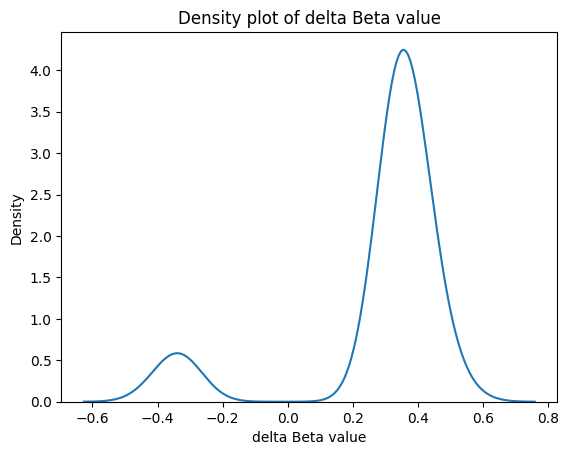

In [110]:
# DEBUG
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(TSS_threshold["dbeta"])
plt.xlabel("delta Beta value")
plt.title("Density plot of delta Beta value")
# END

In [ ]:
# train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")

In [111]:
normal_count = (train_df.iloc[-1, 1:] == 0).sum()
df_gene = train_df.iloc[:-1, :]
df_gene = df_gene[df_gene[df_gene.columns[0]].isin(dbeta["ID"])]
X = df_gene.iloc[:, 1:].reset_index(drop=True).T
y = [0 if i < normal_count else 1 for i in range(X.shape[0])]
# DEBUG
print(f"X shape: {X.shape}")
print(f"y shape: {len(y)}")
# END

X shape: (1086, 14419)
y shape: 1086


In [112]:
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

df = pd.DataFrame(
    {
        "Principal Component 1": X_pca[:, 0],
        "Principal Component 2": X_pca[:, 1],
        "Principal Component 3": X_pca[:, 2],
        "Class": y,
    }
)
print(df.shape)
fig = px.scatter_3d(
    df,
    x="Principal Component 1",
    y="Principal Component 2",
    z="Principal Component 3",
    color="Class",
    title="PCA of Dataset",
    color_continuous_scale="Viridis",
)

fig.update_layout(
    scene=dict(
        xaxis_title="Principal Component 1",
        yaxis_title="Principal Component 2",
        zaxis_title="Principal Component 3",
    )
)

# fig.show()

fig.write_html(f"{trainOutPath}/preprocess_filtering_pca.html")
# open in browser

(1086, 4)


### Sec. 3 Machine Learning
1. remove hypo-methylated genes
2. RFE
3. RFECV (tbd)

#### 3.1 Preparation

In [122]:
config = load_config(CONFIG_PATH)
threshold = config["preprocess"]["filtering"]["threshold"]
TSS_threshold = pd.read_csv(f"{trainOutPath}/dbeta_TSS_{threshold}.csv")

In [123]:
TSS_threshold_hyper = TSS_threshold[TSS_threshold["dbeta"] > 0]
# DEBUG
TSS_threshold_hyper
# END

,ID,gene,dbeta,feature
0,cg22960869,ABI3,0.316896,TSS200
1,cg10372476,ACTN2,0.359817,TSS1500
2,cg13940160,ADNP,0.337048,TSS1500
3,cg05963618,ADRA1B,0.341260,TSS1500
4,cg13862210,AGTRAP,0.324733,TSS200
...,...,...,...,...
316,cg06225133,ZNF35,0.373359,TSS200
317,cg26151087,ZNF493,0.341111,TSS200
318,cg11967894,ZNF585A,0.329522,TSS1500
320,cg00386702,ZNF780B,0.362745,TSS1500


In [124]:
train_df = pd.read_csv(f"{trainOutPath}/all_beta_normalized_0.csv")
test_df = pd.read_csv(f"{testOutPath}/all_beta_normalized_1.csv")

In [125]:
X_train = train_df[train_df["Unnamed: 0"].isin(TSS_threshold_hyper["ID"])]
X_test = test_df[test_df["Unnamed: 0"].isin(TSS_threshold_hyper["ID"])]

In [126]:
X_train = X_train.iloc[:, 1:].T.values.tolist()
X_test = X_test.iloc[:, 1:].T.values.tolist()

In [127]:
config = load_config(CONFIG_PATH)
normal_count_train = config["preprocess"]["merge_and_split"][
    "training_class_distribution"
][0]
normal_count_test = config["preprocess"]["merge_and_split"][
    "testing_class_distribution"
][0]
y_train = [0 if i < normal_count_train else 1 for i in range(len(X_train))]
y_test = [0 if i < normal_count_test else 1 for i in range(len(X_test))]

#### 3.2 Training

In [128]:
import pandas as pd
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from utils.train_helper import set_parameters, append_to_file, record

In [129]:
selection_models = {
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(kernel="linear", random_state=42),
}

param_xgb = {
    "learning_rate": [0.001, 0.01, 0.1],
    "n_estimators": [50, 100, 200],
    "max_depth": [2, 3, 4],
    "subsample": [0.6, 0.7, 0.8],
    "colsample_bytree": [0.6, 0.7, 0.8],
    "min_child_weight": [40, 50, 60],
}

param_rf = {
    "n_estimators": [50, 100, 150, 200],
    "min_samples_split": [80, 90],
    "min_samples_leaf": [80, 90],
    "max_features": [5, 10, 20],
}

param_svm = {"kernel": ["rbf", "poly", "sigmoid"], "C": [50, 100, 200]}

param_dt = {
    "min_samples_split": [70, 80, 90],
    "min_samples_leaf": [70, 80, 90],
    "max_features": [5, 10, 20],
}

xgb_model = set_parameters(XGBClassifier(random_state=42), param_xgb)
rf_model = set_parameters(RandomForestClassifier(random_state=42), param_rf)
svm_model = set_parameters(SVC(random_state=42), param_svm)
dt_model = set_parameters(DecisionTreeClassifier(random_state=42), param_dt)

train_models = {
    "XGBoost": xgb_model,
    "Random Forest": rf_model,
    "Decision Tree": dt_model,
    "SVM": svm_model,
}


In [ ]:
for selection_model_name, selection_model in selection_models.items():
    for feature_count in range(25, 36, 5):
        rfe = RFE(estimator=selection_model, n_features_to_select=feature_count)
        X_train_rfe = rfe.fit_transform(X_train, y_train)
        X_test_rfe = rfe.transform(X_test)
        selected_feature_names = (
            pd.DataFrame(TSS_threshold_hyper.iloc[rfe.support_, 1])
            .reset_index(drop=True)
            .T
        )

        label = f"{selection_model_name}_{feature_count}"

        selected_feature_names.insert(0, "selection_model_name", label)

        append_to_file(
            f"{trainOutPath}/selected_feature_names.csv", selected_feature_names
        )

        for train_model_name, train_model in train_models.items():
            train_model.fit(X_train_rfe, y_train)
            best_params = train_model.best_params_

            best_score = train_model.best_score_

            record(
                train_model.best_estimator_,
                X_train_rfe,
                y_train,
                selection_model_name,
                train_model_name,
                feature_count,
                best_score,
                best_params,
                f"{trainOutPath}",
            )
            record(
                train_model.best_estimator_,
                X_test_rfe,
                y_test,
                selection_model_name,
                train_model_name,
                feature_count,
                best_score,
                best_params,
                f"{testOutPath}",
            )

#### 3.3 Visualization

In [130]:
fpr_tpr_tr = pd.read_csv(f"{trainOutPath}/fpr_tpr.csv")
fpr_tpr_te = pd.read_csv(f"{testOutPath}/fpr_tpr.csv")

In [131]:
rfe_tr = pd.read_csv(f"{trainOutPath}/rfe.csv")
rfe_te = pd.read_csv(f"{testOutPath}/rfe.csv")

In [132]:
rfe_j = pd.merge(rfe_tr, rfe_te, on=["selection_model", "train_model", "features"], suffixes=('_train', '_test'))
fpr_tpr_j = pd.merge(fpr_tpr_tr, fpr_tpr_te, on=["selection_model", "train_model", "features"], suffixes=('_train', '_test'))
J = pd.merge(rfe_j, fpr_tpr_j, on=["selection_model", "train_model", "features", "AUC_train", "AUC_test"])

In [133]:
import ast

J["fpr_train"] = J["fpr_train"].apply(ast.literal_eval)
J["tpr_train"] = J["tpr_train"].apply(ast.literal_eval)
J["fpr_test"] = J["fpr_test"].apply(ast.literal_eval)
J["tpr_test"] = J["tpr_test"].apply(ast.literal_eval)

In [143]:
import plotly.graph_objects as go

fig = go.Figure()

for index, row in J.iterrows():
    fig.add_trace(go.Scatter(
        x=row['fpr_train'],
        y=row['tpr_train'],
        mode='lines',
        name=f"{row['selection_model']} {row['train_model']} (AUC = {row['AUC_train']:.3f})"
    ))

# Add the random guess line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='grey'),
    name='Random Guess'
))

# Update layout
fig.update_layout(
    title='ROC Curves on Training Set',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',\
    
    legend_title='Model',
    template='plotly_white',
    width=800,  # Set the width of the canvas
    height=1200   # Set the height of the canvas
)

fig.show()


In [144]:
import plotly.graph_objects as go

fig = go.Figure()

for index, row in J.iterrows():
    fig.add_trace(go.Scatter(
        x=row['fpr_test'],
        y=row['tpr_test'],
        mode='lines',
        name=f"{row['selection_model']} {row['train_model']} (AUC = {row['AUC_test']:.3f})"
    ))

# Add the random guess line
fig.add_trace(go.Scatter(
    x=[0, 1],
    y=[0, 1],
    mode='lines',
    line=dict(dash='dash', color='grey'),
    name='Random Guess'
))

# Update layout
fig.update_layout(
    title='ROC Curves for Different Models',
    xaxis_title='False Positive Rate (FPR)',
    yaxis_title='True Positive Rate (TPR)',\
    
    legend_title='Model',
    template='plotly_white',
    width=800,  # Set the width of the canvas
    height=1200   # Set the height of the canvas
)

fig.show()


In [145]:
J["selection_train_model_features"] = J["selection_model"] + "" + J["train_model"] + "" + J["features"].astype(str)

In [146]:
# plot the accuracy difference using ploty

my_custom = dict({
    "accuracy": "blue",
    "recall": "red",
    "precision": "purple",
    "f1_score": "orange",
    "J-index": "cyan",
    "AUC": "green",
    "MCC": "black"
})

fig = go.Figure()

for key, value in my_custom.items():
    fig.add_trace(go.Scatter(
        x=J[f'{key}_train'] - J[f'{key}_test'],
        y=J['selection_train_model_features'],
        mode='lines+markers',
        name=f'{key} Difference',
        line=dict(color=value, width=2),
        marker=dict(color=value, size=8)
    ))


# Update layout
fig.update_layout(
    title='Performance Difference between Training and Testing Set',
    xaxis_title='Performance Difference (Training - Testing)',
    yaxis_title='Combination of Selection Model, Train Model and Features',
    template='plotly_white',
    width=800,  # Set the width of the canvas
    height=800   # Set the height of the canvas
)

fig.show()

### Sec. 4 Clustering

#### 4.1 load data

In [8]:
import pandas as pd
import numpy as np
from utils.clustering_helper import hierarchical_clustering, check_distance_matrix

In [9]:
dbeta_path = config["clustering"]["hyper"]["dbeta_file"]
gene_set_file = config["clustering"]["hyper"]["gene_set_file"]
bp_file = config["clustering"]["hyper"]["bp_file"]
cc_file = config["clustering"]["hyper"]["cc_file"]
mf_file = config["clustering"]["hyper"]["mf_file"]
terms_count_file = config["clustering"]["hyper"]["terms_count_file"]

In [10]:
dbeta = pd.read_csv(f"{trainOutPath}/{dbeta_path}.csv", index_col=0)
gene_set = pd.read_csv(f"{trainOutPath}/{gene_set_file}.csv", index_col=0)
distance_matrix_bp = pd.read_csv(f"{trainOutPath}/{bp_file}.csv", index_col=0)
distance_matrix_cc = pd.read_csv(f"{trainOutPath}/{cc_file}.csv", index_col=0)
distance_matrix_mf = pd.read_csv(f"{trainOutPath}/{mf_file}.csv", index_col=0)
terms_count = pd.read_csv(f"{trainOutPath}/{terms_count_file}.csv", index_col=0)

In [11]:
# replace NaN with 0
distance_matrix_bp = distance_matrix_bp.fillna(0)
distance_matrix_cc = distance_matrix_cc.fillna(0)
distance_matrix_mf = distance_matrix_mf.fillna(0)

In [12]:
# reindex distance matrix
index_bp = distance_matrix_bp.index
index_cc = distance_matrix_cc.index
index_mf = distance_matrix_mf.index
index = index_bp.union(index_cc).union(index_mf)
distance_matrix_bp_ = distance_matrix_bp.reindex(index=index, columns=index, fill_value=0)
distance_matrix_cc_ = distance_matrix_cc.reindex(index=index, columns=index, fill_value=0)
distance_matrix_mf_ = distance_matrix_mf.reindex(index=index, columns=index, fill_value=0)

In [13]:
# make a array of distance matrix for each ontology
distance_matrix = []

distance_matrix.append(distance_matrix_bp_)
distance_matrix.append(distance_matrix_cc_)
distance_matrix.append(distance_matrix_mf_)

#### 4.2 Weighted Sum

In [14]:
weight = [count for count in terms_count["count"]]
weight = weight / np.sum(weight)
masks = np.array([~np.isnan(distance_matrix[i].values) for i in range(3)])

valid_weights = np.array([weight[i] for i in range(3)])[:, None, None] * masks

weight_sums = valid_weights.sum(axis=0)

normalized_weights = np.divide(valid_weights, weight_sums, where=weight_sums != 0)
weighted_sum = sum(
    np.nan_to_num(distance_matrix[i].values) * normalized_weights[i] for i in range(3)
)


weighted_sum_dataframe = pd.DataFrame(weighted_sum, index=index, columns=index)

weighted_sum_dataframe.head()

,ADRA1B,AGTRAP,AKR1A1,ALPP,ANKRD27,ANKRD30B,APP,ARFGAP1,ARID2,ARSJ,...,TMCO4,TMEM169,TOM1,TP53BP2,TXNRD1,TYSND1,VAT1L,WDR90,ZBTB25,ZDHHC2
ADRA1B,0.000000,0.518477,0.770986,0.681194,0.708385,0.623789,0.641848,0.621846,0.654708,0.252377,...,0.029706,0.029706,0.506772,0.414326,0.483105,0.788020,0.115363,0.616456,0.675822,0.729552
AGTRAP,0.518477,0.000000,0.808264,0.787632,0.741039,0.678961,0.710950,0.710393,0.707185,0.246240,...,0.029706,0.029706,0.654522,0.578707,0.629854,0.801016,0.120929,0.665838,0.717541,0.793623
AKR1A1,0.770986,0.808264,0.000000,0.698041,0.800354,0.638788,0.733740,0.768708,0.773014,0.256960,...,0.045461,0.045461,0.714120,0.667251,0.675938,0.710617,0.098413,0.650166,0.785678,0.769448
ALPP,0.681194,0.787632,0.698041,0.000000,0.751877,0.655596,0.579392,0.647718,0.690396,0.166109,...,0.018697,0.018697,0.688787,0.612311,0.658800,0.781692,0.068307,0.665217,0.766763,0.803919
ANKRD27,0.708385,0.741039,0.800354,0.751877,0.000000,0.697330,0.665425,0.436327,0.697147,0.254780,...,0.000000,0.000000,0.450774,0.651103,0.693610,0.810471,0.122952,0.556236,0.757875,0.723442


chosen number of clusters: 3


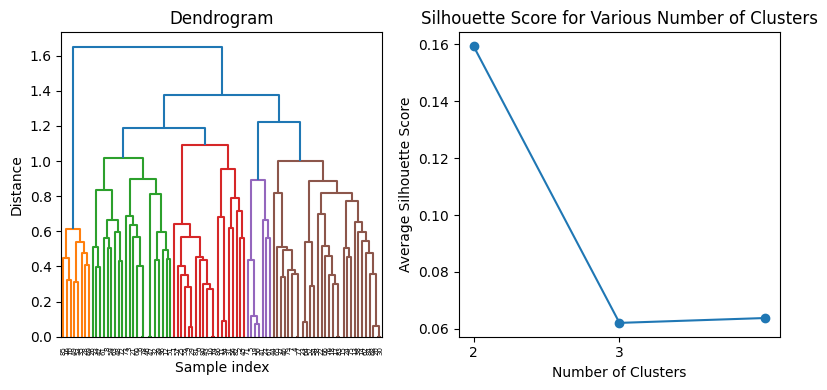

In [15]:
cluster_result_weighted = hierarchical_clustering(
    weighted_sum_dataframe, range_min=2, range_max=4, cluster_number=3
)

In [16]:
cluster_result_weighted.head()

,gene,cluster
0,ADRA1B,2
1,AGTRAP,2
2,AKR1A1,2
3,ALPP,2
4,ANKRD27,3


#### 4.3 Simple average

In [17]:
weight = [1, 1, 1]
masks = np.array([~np.isnan(distance_matrix[i].values) for i in range(3)])
valid_weights = np.array([weight[i] for i in range(3)])[:, None, None] * masks
weight_sums = valid_weights.sum(axis=0)
normalized_weights = np.divide(valid_weights, weight_sums, where=weight_sums != 0)
weighted_sum = sum(
    np.nan_to_num(distance_matrix[i].values) * normalized_weights[i] for i in range(3)
)
simple_sum_dataframe = pd.DataFrame(weighted_sum, index=index, columns=index)
simple_sum_dataframe.head()

,ADRA1B,AGTRAP,AKR1A1,ALPP,ANKRD27,ANKRD30B,APP,ARFGAP1,ARID2,ARSJ,...,TMCO4,TMEM169,TOM1,TP53BP2,TXNRD1,TYSND1,VAT1L,WDR90,ZBTB25,ZDHHC2
ADRA1B,0.000000,0.420667,0.666000,0.570000,0.549000,0.603333,0.560333,0.552333,0.528667,0.453333,...,0.104333,0.104333,0.441333,0.351000,0.454333,0.639000,0.152000,0.456667,0.542333,0.640333
AGTRAP,0.420667,0.000000,0.710667,0.659333,0.555000,0.650333,0.592000,0.572667,0.576333,0.434000,...,0.104333,0.104333,0.511000,0.470667,0.537333,0.651667,0.159333,0.483333,0.581333,0.627333
AKR1A1,0.666000,0.710667,0.000000,0.647000,0.677667,0.611000,0.623000,0.634333,0.710333,0.445000,...,0.159667,0.159667,0.590000,0.564333,0.565333,0.649000,0.129667,0.487000,0.739000,0.715333
ALPP,0.570000,0.659333,0.647000,0.000000,0.639667,0.595667,0.551000,0.579000,0.573333,0.344667,...,0.065667,0.065667,0.584333,0.558000,0.633000,0.670333,0.090000,0.518333,0.686333,0.735667
ANKRD27,0.549000,0.555000,0.677667,0.639667,0.000000,0.617000,0.527333,0.404667,0.594000,0.452333,...,0.000000,0.000000,0.372000,0.509333,0.568333,0.644333,0.162000,0.419333,0.597667,0.636333


chosen number of clusters: 3


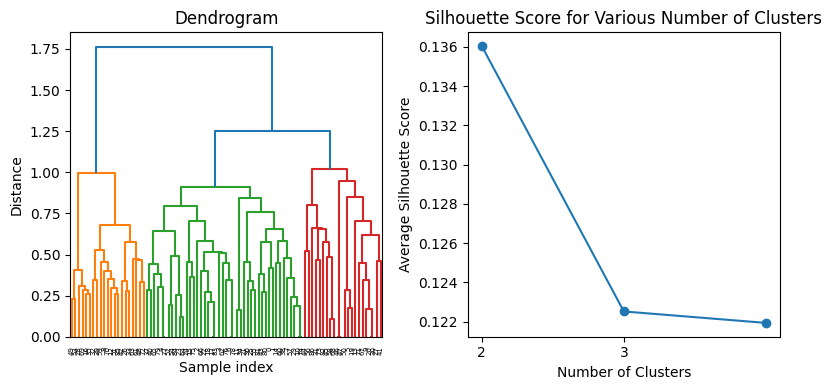

In [19]:
cluster_result_simple = hierarchical_clustering(
    simple_sum_dataframe, range_min=2, range_max=4, cluster_number=3
)

In [20]:
cluster_result_simple.head()

,gene,cluster
0,ADRA1B,2
1,AGTRAP,2
2,AKR1A1,2
3,ALPP,2
4,ANKRD27,2


#### 4.4 Consensus clustering 

Best number of clusters: 29


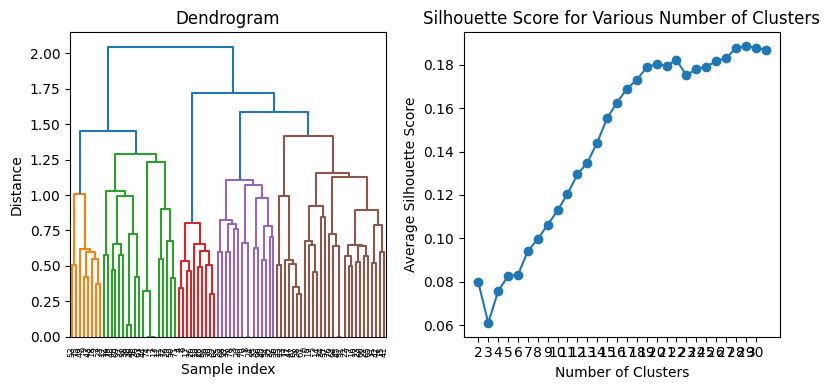

Best number of clusters: 7


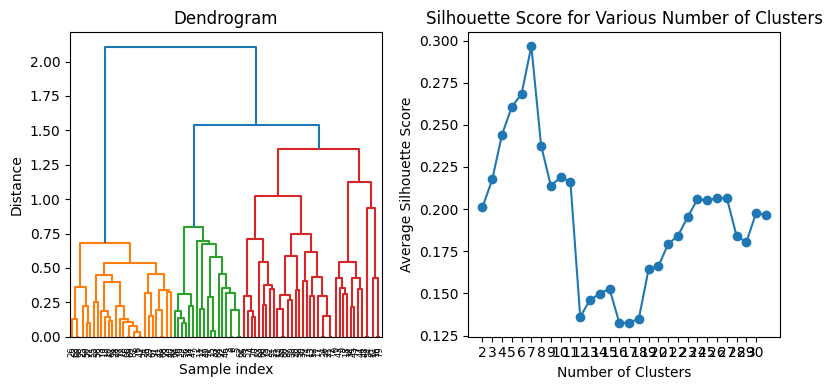

Best number of clusters: 3


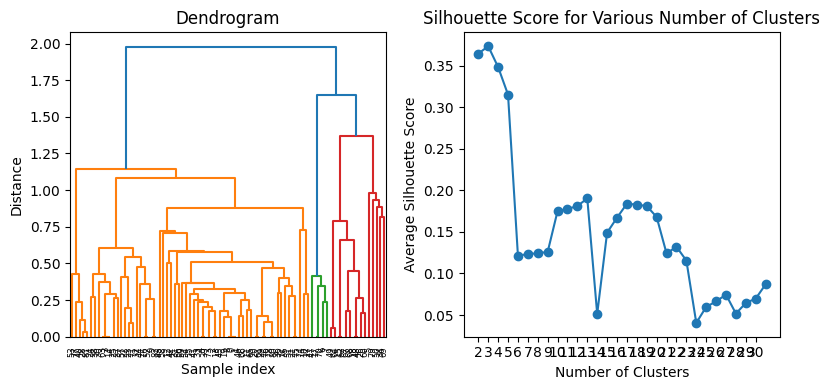

In [21]:
cluster_bp = hierarchical_clustering(distance_matrix_bp)
cluster_cc = hierarchical_clustering(distance_matrix_cc)
cluster_mf = hierarchical_clustering(distance_matrix_mf)

In [22]:
cluster_bp.columns = ["gene", "cluster_bp"]
cluster_cc.columns = ["gene", "cluster_cc"]
cluster_mf.columns = ["gene", "cluster_mf"]
cluster_bp_cc = pd.merge(cluster_bp, cluster_cc, on="gene", how="outer")
cluster_go = pd.merge(cluster_bp_cc, cluster_mf, on="gene", how="outer")
cluster_go = cluster_go.fillna(-1)
print(cluster_go.shape)
cluster_go.head()

(87, 4)


,gene,cluster_bp,cluster_cc,cluster_mf
0,ADRA1B,11.0,1.0,1.0
1,AGTRAP,24.0,3.0,1.0
2,AKR1A1,18.0,5.0,1.0
3,ALPP,17.0,4.0,1.0
4,ANKRD27,2.0,4.0,1.0


In [23]:
num_genes = cluster_go.shape[0]
consensus_matrix = np.zeros((num_genes, num_genes))

for i in range(num_genes):
    for j in range(i, num_genes):
        if cluster_go.iloc[i]["cluster_bp"] == cluster_go.iloc[j]["cluster_bp"]:
            consensus_matrix[i][j] += 1

        if cluster_go.iloc[i]["cluster_cc"] == cluster_go.iloc[j]["cluster_cc"]:
            consensus_matrix[i][j] += 1

        if cluster_go.iloc[i]["cluster_mf"] == cluster_go.iloc[j]["cluster_mf"]:
            consensus_matrix[i][j] += 1


consensus_matrix = pd.DataFrame(
    consensus_matrix, index=cluster_go["gene"], columns=cluster_go["gene"]
)
consensus_matrix += consensus_matrix.T


distance_matrix_consensus = 1 - consensus_matrix / 3
np.fill_diagonal(distance_matrix_consensus.values, 0)


distance_matrix_consensus.head()

gene,ADRA1B,AGTRAP,AKR1A1,ALPP,ANKRD27,ANKRD30B,APP,ARFGAP1,ARID2,ARSJ,...,TMCO4,TMEM169,TOM1,TP53BP2,TXNRD1,TYSND1,VAT1L,WDR90,ZBTB25,ZDHHC2
gene,,,,,,,,,,,,,,,,,,,,,
ADRA1B,0.000000,0.666667,0.666667,0.666667,0.666667,1.0,0.666667,0.666667,0.333333,1.000000,...,0.666667,1.000000,0.666667,0.000000,0.000000,0.666667,0.666667,0.666667,0.666667,0.666667
AGTRAP,0.666667,0.000000,0.666667,0.666667,0.666667,1.0,0.666667,0.666667,0.666667,1.000000,...,0.666667,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,1.000000,0.333333
AKR1A1,0.666667,0.666667,0.000000,0.666667,0.666667,1.0,0.666667,0.666667,0.666667,0.666667,...,0.666667,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,1.000000,0.666667
ALPP,0.666667,0.666667,0.666667,0.000000,0.333333,1.0,0.333333,0.666667,0.666667,1.000000,...,0.333333,0.666667,0.333333,0.666667,0.666667,0.333333,0.666667,0.666667,1.000000,0.666667
ANKRD27,0.666667,0.666667,0.666667,0.333333,0.000000,1.0,0.333333,0.333333,0.666667,1.000000,...,0.333333,0.666667,0.000000,0.666667,0.666667,0.333333,0.666667,0.666667,1.000000,0.666667


chosen number of clusters: 4


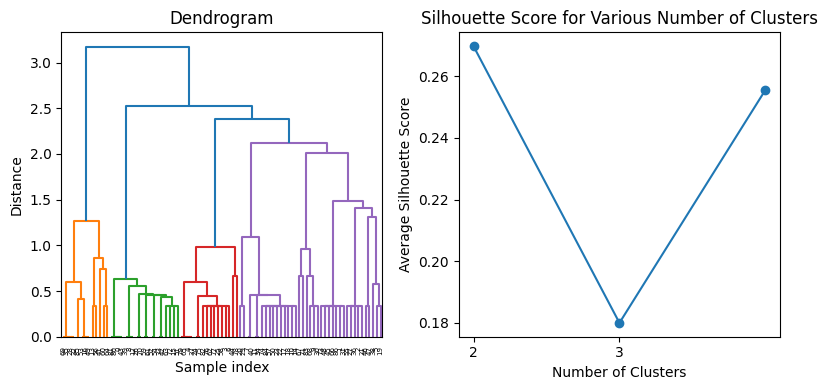

In [25]:
cluster_result_consensus = hierarchical_clustering(
    distance_matrix_consensus, range_min=2, range_max=4, cluster_number=4
)

In [26]:
cluster_result_consensus.head()

,gene,cluster
0,ADRA1B,2
1,AGTRAP,4
2,AKR1A1,4
3,ALPP,3
4,ANKRD27,3


#### 4.5 Compare 

Best number of clusters for Weighted Average: 2
Best number of clusters for Simple Average: 2
Best number of clusters for Consensus: 5


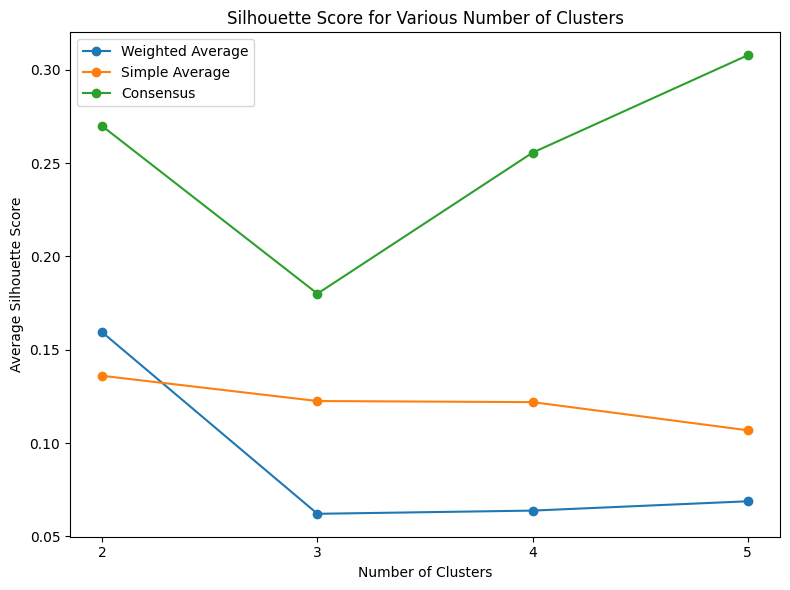

In [27]:
from utils.clustering_helper import hierarchical_clustering_compare
hierarchical_clustering_compare(
    [weighted_sum_dataframe, simple_sum_dataframe, distance_matrix_consensus],
    ["Weighted Average", "Simple Average", "Consensus"],
)

In [28]:
dbeta["ID"] = dbeta.index

In [29]:
# column gene isin weighted_sum_dataframe
weighted_dbeta = dbeta[dbeta["gene"].isin(weighted_sum_dataframe.index)]
simple_dbeta = dbeta[dbeta["gene"].isin(simple_sum_dataframe.index)]
consensus_dbeta = dbeta[dbeta["gene"].isin(distance_matrix_consensus.index)]

In [31]:
weighted_dbeta.merge(cluster_result_weighted, on="gene").to_csv(
    f"{trainOutPath}/{dbeta_path}_weighted.csv", index=False
)
simple_dbeta.merge(cluster_result_simple, on="gene").to_csv(
    f"{trainOutPath}/{dbeta_path}_simple.csv", index=False
)
consensus_dbeta.merge(cluster_result_consensus, on="gene").to_csv(
    f"{trainOutPath}/{dbeta_path}_consensus.csv", index=False
)

### Sec. 5 Combination